In [10]:
import pandas as pd

classification_df = pd.read_csv('data/classification.csv')
classification_df.head()

,room_type,latitude,longitude,accommodates,beds,price,bathrooms,half_bathrooms,shared_bathrooms
0,Entire_home/apt,-22.96599,-43.17940,5,2.0,1357.0,1,0,0
1,Entire_home/apt,-22.97735,-43.19105,3,1.0,865.0,1,0,0
2,Entire_home/apt,-22.98107,-43.19136,2,1.0,373.0,1,1,0
3,Entire_home/apt,-22.96825,-43.18237,4,1.0,366.0,1,0,0
4,Entire_home/apt,-22.97696,-43.18933,5,3.0,368.0,2,0,0


In [11]:
labels = list(classification_df.loc[:, 'room_type'].unique())
label_remapper = {label: i for i, label in enumerate(labels)}
classification_df['target'] = classification_df.loc[:, 'room_type'].apply(lambda label: label_remapper[label])

X = classification_df.loc[:, ['latitude', 'longitude', 'accommodates', 'beds', 'price', 'bathrooms', 'half_bathrooms', 'shared_bathrooms']]
X = (X - X.mean())/X.std() #Normalizing

y = classification_df.loc[:, 'target']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt

def cross_validate(model, X, y, k_folds = 5, score_function = accuracy_score, plot_loss = True):
    cumulative_score = 0
    
    if plot_loss: cumulative_loss = [0]*model.n_iter_

    for i, (train_index, val_index) in enumerate(KFold(k_folds, shuffle = True, random_state = 57).split(X,y)):
        X_train = X.loc[train_index]
        y_train = y.loc[train_index]
        X_val = X.loc[val_index]
        y_val = y.loc[val_index]

        regressor = model.fit(X_train.values, y_train.values)
        y_predicted = regressor.predict(X_val)

        partial_score = score_function(y_val, y_predicted)

        print(f'\t{i+1}-fold score: {round(partial_score, 4)}', end = '')

        cumulative_score += partial_score

        if plot_loss:
            for i, loss in enumerate(regressor.loss_curve_): cumulative_loss[i] += loss
    
    if plot_loss:
        cumulative_loss = [loss/k_folds for loss in cumulative_loss]
        plt.plot(cumulative_loss)
        plt.show()
    
    return regressor, cumulative_score/k_folds



In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')


layer_length = 8
n_layers = 4

models = [RandomForestClassifier(random_state=14166), GradientBoostingClassifier(random_state=14166), GaussianNB(), SVC(random_state=14166)]
trained_models = []
scores = []

best_model = None
best_score = 0    

for model in models:
    print(f'Validating model: {model}')
    trained_model, score = cross_validate(model, X_train, y_train, k_folds=5, plot_loss = False) 
    scores.append(score)
    trained_models.append(trained_model)
    print(f'\nFinished evaluation with score: {score}\n')

    if score > best_score:
        best_score = score
        best_model = trained_model

print(f'\nBest model: {best_model} - score: {best_score}')

Validating model: RandomForestClassifier(random_state=14166)
	1-fold score: 0.9036	2-fold score: 0.9122	3-fold score: 0.8986	4-fold score: 0.9079

KeyboardInterrupt: 

In [16]:
from sklearn.metrics import precision_recall_fscore_support

#Final evaluation

best_model = RandomForestClassifier(random_state=14166)
trained = best_model.fit(X_train, y_train)

y_predicted = trained.predict(X_test)

accuracy = accuracy_score(y_test, y_predicted)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_predicted, average = 'macro')

print("Scores finais de teste:")
print(f'Acurácia: {accuracy}')
print(f'Precisão média: {precision}')
print(f'Revocação média: {recall}')
print(f'F1 médio: {f1}')

Scores finais de teste:
Acurácia: 0.9096331643304504
Precisão média: 0.886878029533883
Revocação média: 0.5666542388280336
F1 médio: 0.6178387925856578


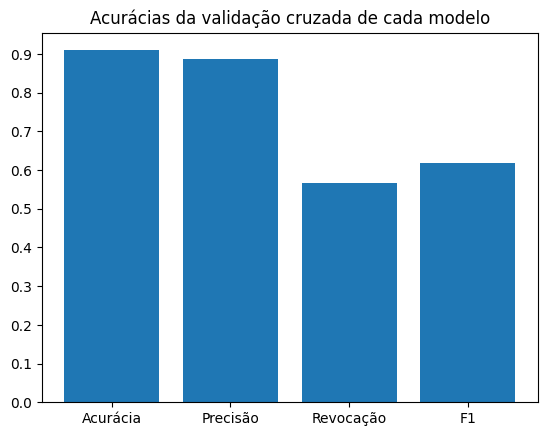

In [18]:
import matplotlib.pyplot as plt

plt.bar(['Acurácia', 'Precisão', 'Revocação', 'F1'], [0.9096,0.8868,0.5667, 0.6178])
plt.yticks([k/100 for k in range(0,100,10)])
plt.title('Acurácias da validação cruzada de cada modelo')
plt.show()